In [91]:
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import scipy  # type: ignore
from scipy.integrate import quad, dblquad # type: ignore
import pandas as pd # type: ignore
import os

# 将工作目录设置为 ../ 目录
os.chdir('c:/Users/dell/Desktop/24_11_work/Phase_Curve_2_TMap')
print(os.getcwd())

def fit_function(x, F0, C1, D1, C2, D2):  # Fitting Function
    # Cowan, Nicolas B., and Eric Agol. “Inverting Phase Functions to Map Exoplanets.” 
    # The Astrophysical Journal 678, no. 2 (May 10, 2008): L129–32.
    # https://doi.org/10.1086/588553.
    return F0 + C1*np.cos(x) + D1*np.sin(x) + C2*np.cos(2*x) + D2*np.sin(2*x)   # 到二阶
    

class PHASE_CURVE:  # Phase Curve Class
    class FITS: # Fits Class, stores the fitting parameters of the phase curve
        def __init__(self, parent, F0, C1, D1, C2, D2, pcov):
            self.parent = parent # parent class reference
            self.F0 = F0
            self.C1 = C1
            self.D1 = D1
            self.C2 = C2
            self.D2 = D2
            self.pars = np.array([F0, C1, D1, C2, D2])
            # self.chi_square = np.sum(((self.parent.fit_function(self.parent.phase, F0, C1, D1, C2, D2) - self.parent.contrast_ratio)**2)/np.diag(pcov))
            # self.perr = np.sqrt(np.diag(pcov))
            
    class SYS_PARS: # System Parameters Class, stores the parameters of planet and star
        def __init__(self, Nline):
            data_base = pd.read_csv('./data/PS.csv', header = 96)
            row_data = data_base.iloc[Nline]
            ### orbital parameters
            self.AU = 149597870.7  # km, Astronomical Unit
            self.Rs = row_data['st_rad'] * 696340  # km, radius of the Star
            self.Rp = row_data['pl_rade'] * 6371.4  # km, radius of the Planet
            self.eccentricity = 0 # row_data['pl_orbeccen'] # Eccentricity of the planet's orbit
            self.semi_axis = row_data['pl_orbsmax'] * self.AU  # km, semi-major axis of the planet's orbit
            ### Thermal and optical parameters
            self.Stellar_T = row_data['st_teff'] # K, temperature of the Star
            # self.pl_eqT = row_data['pl_eqt']  # K, fully redistribution, planet equilibrium Temperature [K] (from database)
            self.pl_eqT = self.Stellar_T * np.sqrt(self.Rs / 2 /self.semi_axis)  # from theoretical calculation
            
    class OBS_PARS: # Observation Parameters Class, stores the parameters of the observation
        def __init__(self, lambda_range, **kwargs):
            # kwargs list:
            #   instrument, exposure_time, observation_time, filter, etc.
            self.lam_min = lambda_range[0] # minimum wavelength of the observation
            self.lam_max = lambda_range[1] # maximum wavelength of the observation
            
            self.instrument = kwargs.get('instrument', 'null') # name of the instrument
            self.filter = kwargs.get('filter', 'null') # filter of the observation
            self.exposure_time = kwargs.get('exposure_time', np.nan) # exposure time of the observation
            self.observation_time = kwargs.get('observation_time', np.nan) # observation time of the observation
            
            
    def __init__(self, x_data, y_data):
        # Initialization of Phase Curve Class
        self.phase = x_data # orbital phase data
        self.contrast_ratio = y_data # contrast ratio data
        self.type = "Phase Curve" # type of data
        
        popt, pcov = scipy.optimize.curve_fit(fit_function, self.phase, self.contrast_ratio) # fitting the phase curve
        self.Fits = self.FITS(self, *popt, pcov) # storing the fitting parameters, Initialize the FITS class
        self.Sys_Pars = self.SYS_PARS(733 - 98) # storing the astronomy parameters, Initialize the SYS_PARS class
        self.Obs_Pars = self.OBS_PARS([2.4 *1e-6, 4 *1e-6]) # storing the observation parameters, Initialize the OBS_PARS class

    
    def Plot(self):  # Plotting Function
        plt.figure(figsize=(10, 6))
        plt.plot(self.phase, self.contrast_ratio, 'o', label='data')
        phase_list = np.linspace(-np.pi, np.pi, 100)
        plt.plot(phase_list, fit_function(phase_list, *self.Fits.pars), label='fit')
        plt.xlabel('Phase')
        plt.ylabel('Contrast Ratio')
        plt.legend()
        plt.show()



c:\Users\dell\Desktop\24_11_work\Phase_Curve_2_TMap


In [92]:
def B(lam,T):
    # !!!Totally same with function: blackbody_radiation(T,lam)!!!
    h = 6.626e-34  # Planck's constant
    c = 3.0e8  # Speed of light
    k = 1.38e-23  # Boltzmann constant
    A = (np.exp(h * c / lam / k / T) - 1)
    B = 2* h * c**2 / lam**5 / A
    return B

class TO_MAP:  # TMap Class
    def __init__(self, phase_curve):
        self.phase_curve = phase_curve   #import the phase curve data
        self.T_pars = self.inversion(phase_curve.Fits.pars) # inversion the parameters
        self.average_T() # calculate the average temperature of the planet
        
    def inversion(self, pars):
        # Cowan, Nicolas B., and Eric Agol. “Inverting Phase Functions to Map Exoplanets.” Journal of Geophysical Research 102.4 (1997): 8365–8378.
        coeff = np.array([2, np.pi/2, -np.pi/2, 2/3, -2/3])
        return coeff * pars
    
    def Plot(self):  # Plotting Function, plot the brightness temperature curve of the planet
        plt.figure(figsize=(10, 6))
        phase_list = np.linspace(-np.pi, np.pi, 100)
        plt.plot(phase_list, fit_function(phase_list, *self.T_pars), label='Brightness Temperature Map')
        plt.xlabel('Phase')
        plt.ylabel('Brightness Temperature')
        plt.legend()
        plt.show()
        
    def PlotT(self): # plot the average temperature curve of the planet
        plt.figure(figsize=(10, 6))
        plt.plot(self.phase_list, self.average_T_list, label='Average Temperature')
        plt.plot(self.phase_list, self.equator_T_list, label='Equator Temperature')
        plt.xlabel('Phase')
        plt.ylabel('Average Temperature (K)')
        plt.legend()
        plt.show()
        
    def average_T(self, **kwargs):
        # calculate the average temperature of the planet
        # kwargs list: phase_list, phase_range
        # sys parameters
        Rp = self.phase_curve.Sys_Pars.Rp
        Rs = self.phase_curve.Sys_Pars.Rs
        Ts = self.phase_curve.Sys_Pars.Stellar_T
        Tp = self.phase_curve.Sys_Pars.pl_eqT
        Albedo = 0
        # obs parameters
        lam1 = self.phase_curve.Obs_Pars.lam_min
        lam2 = self.phase_curve.Obs_Pars.lam_max
        
        Int1, _ = quad(lambda lam: B(lam, Ts), lam1, lam2)  # 此处注意占位符的使用
        C_temp = np.pi * Rs**2 /(2 * Rp**2 *(1-Albedo)) * Int1
        
        # print('Int1: ',Int1)
        # print('Tp: ',Tp)
        def average_T_eq(T, J):  # the equation of average temperature
            Int2, _ = quad(lambda lam: B(lam, T), lam1, lam2)
            return  C_temp * J - Int2
        
        def equator_T_eq(T, J):  # the equation of equator temperature
            Int3, _ = dblquad(lambda lam, theta: B(lam, T * np.sin(theta)**(1/4)) * np.sin(theta), 0, np.pi/2, lam1, lam2)
            return  C_temp * J - Int3
        
        try:
            Phase_list = kwargs['phase_list']
        except:
            Phase_list = np.linspace(-np.pi, np.pi, 20)
        J_list = fit_function(Phase_list, *self.T_pars)
        T_list = np.zeros(len(J_list))
        equator_T_list = np.zeros(len(J_list))
        
        for i, J in enumerate(J_list):
            T_list[i], = scipy.optimize.fsolve(average_T_eq, Tp, args =(J,), xtol=1e-10)
            equator_T_list[i], = scipy.optimize.fsolve(equator_T_eq, Tp, args =(J,), xtol=1e-8)
            
        self.phase_list = Phase_list
        self.average_T_list = T_list
        self.equator_T_list = equator_T_list
        return Phase_list, T_list, equator_T_list
    
        

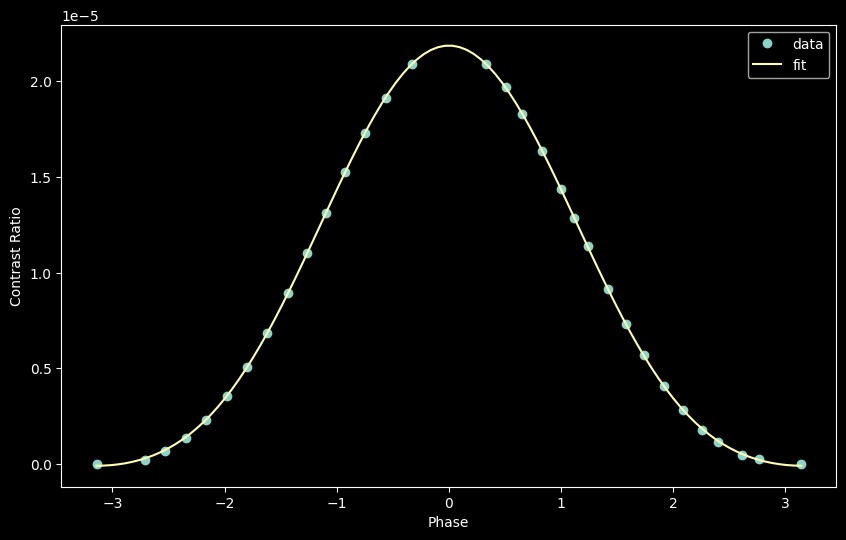

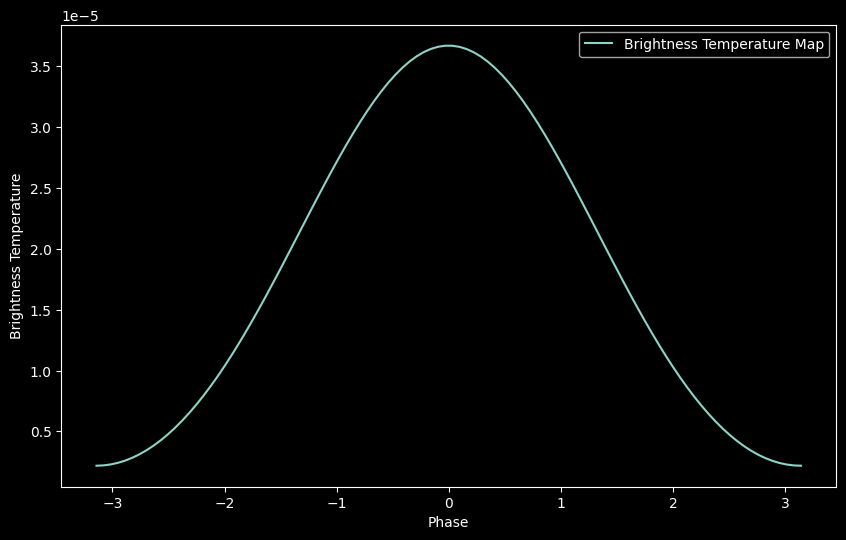

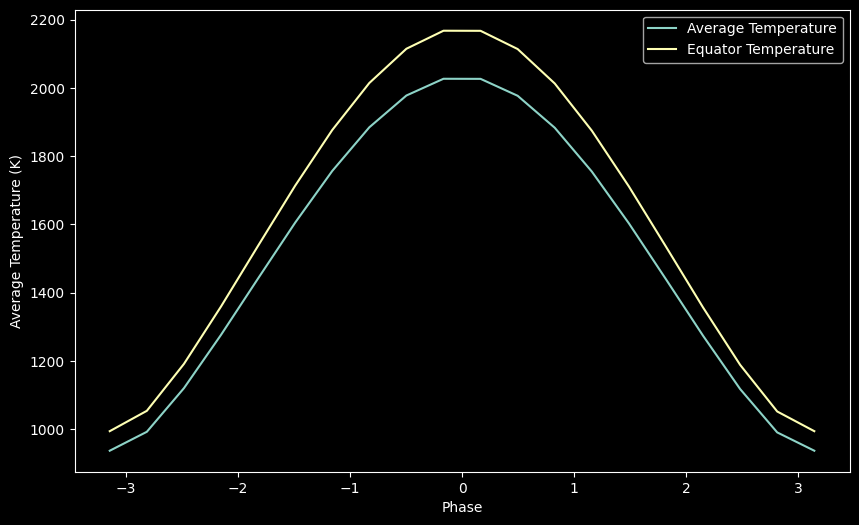

Time:  5.240551233291626  s


In [93]:
import time
t1 = time.time()
# Load the phase curve data from .txt file
file_path = './data/pc_theory.txt'
data = np.loadtxt(file_path, delimiter=',')  # load the data from .txt file
# data按照第一列从小到大排序
data = data[data[:, 0].argsort()]  # sort the data by phase
x_data = (data[:, 0] - 0.5) * 2 * np.pi  # phase data
y_data = data[:, 1] * 1e-6  # contrast ratio data
phase_curve = PHASE_CURVE(x_data, y_data)  # Create a Phase Curve object
phase_curve.Plot()  # Plot the Phase Curve

# convert the phase curve to a brightness temperature map
tmap = TO_MAP(phase_curve)
tmap.Plot()  # Plot the Brightness Temperature Map
tmap.PlotT()  # Plot the Average Temperature Curve

t2 = time.time()
print('Time: ', t2-t1, ' s')

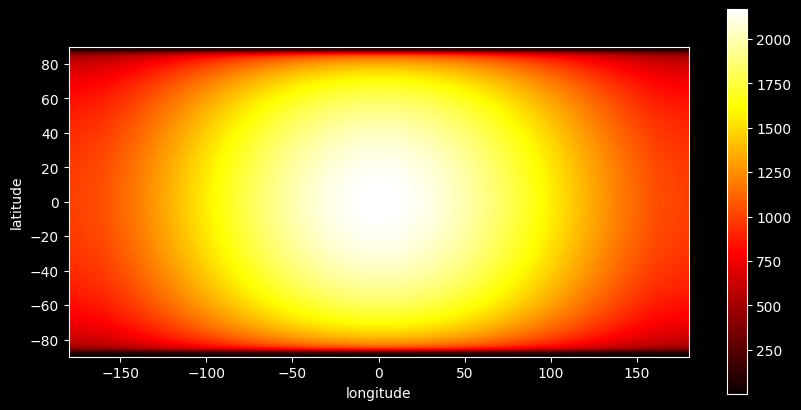

In [94]:
# calculate phase curve map(2D) of the planet
from scipy.interpolate import interp1d # type: ignore
phase_list = tmap.phase_list
equator_T_list = tmap.equator_T_list
# interpolation
spl = interp1d(phase_list, equator_T_list, kind='linear')

longitude_list = np.linspace(-np.pi, np.pi, 100)  
latitude_list = np.linspace(-np.pi/2, np.pi/2, 50)

Tmap = np.zeros((len(latitude_list), len(longitude_list))) # 2D Temperature map

for i, latitude in enumerate(latitude_list):
    for j, longitude in enumerate(longitude_list):
        Tmap[i, j] = spl(longitude) * np.cos(latitude)**(1/4)

def Plot_2Dmap(Tmap, longitude_list, latitude_list):
    fig, ax = plt.subplots(figsize=(10, 5))
    # im = ax.pcolormesh(longitude_list *180/np.pi, latitude_list *180/np.pi, Tmap, cmap = 'hot')
    im = ax.imshow(Tmap, extent=[-180, 180, -90, 90], cmap='hot', interpolation='gaussian')
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    fig.colorbar(im, ax=ax)
    plt.show()
    
Plot_2Dmap(Tmap, longitude_list, latitude_list)